<html>
    <div style="background-color: lightskyblue; padding: 30px; color: black; text-align: center;">
    <h1>CAB420 - Assignment 2</h1>
    <h2>Building a DCNN Model to Classify Animals and Endangered Status</h2>
    </div>
</html>

Loading in the main modules for the project

In [208]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Utility Functions

In [209]:
def load_images_from_folders(root_dir):
    image_paths = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):# Check for common image extensions
                image_path = os.path.join(dirpath, filename)
                image_paths.append(image_path)
    return image_paths

def read_images(image_paths):
    images = []
    for path in image_paths:
        try:
            img = np.array(Image.open(path)) # or img = cv2.imread(path)
            images.append(img)
        except Exception as e:
             print(f"Error loading image: {path} - {e}")
    
    return images

Downloading the datasets and generating the train/test splits

In [210]:
labelled_data = pd.read_csv("data/labelled_data.csv")
unlabelled_data = pd.read_csv("data/unlabelled_data.csv")

In [211]:
labelled_data

,filename_id,species,endangered
0,007_0001,7,0.2
1,007_0002,7,0.6
2,007_0003,7,0.4
3,007_0004,7,0.0
4,007_0005,7,0.0
...,...,...,...
2461,250_0044,250,0.4
2462,250_0045,250,0.2
2463,250_0046,250,0.6
2464,250_0047,250,0.2


In [212]:
image_root = os.path.join(os.getcwd(), 'data', '256_ObjectCategories')
image_paths = load_images_from_folders(image_root)
images = read_images(image_paths)

These images aren't in a standardised format. Going to implement a resize to keep them in the same format

In [ ]:
np_images = []

for i in range(len(images)):
    image_np = np.array(images[i])
    # If image is grayscale, convert to 3 channels
    if image_np.ndim == 2:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    image_np = cv2.resize(image_np, (256, 256))
    image_np = image_np.astype('float32')
    np_images.append(image_np) 

np_images = np.array(np_images)


Visualising the images found

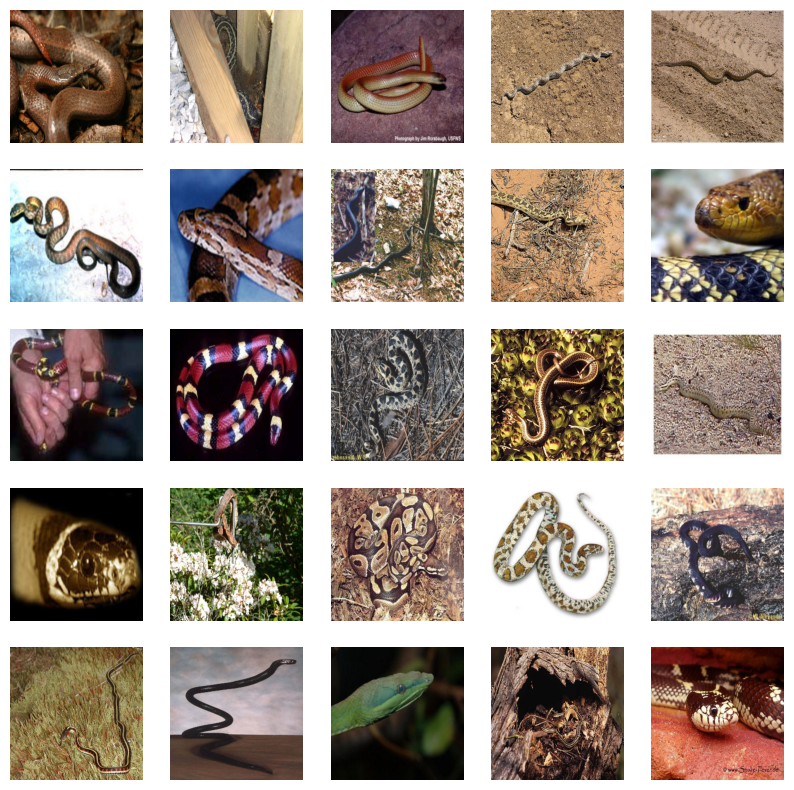

In [221]:
fig = plt.figure(figsize=(10, 10))

image_range = np_images[300:350]

for i in range(len(image_range)):
    try:
        ax = fig.add_subplot(5, 5, i + 1)
        img = image_range[i]

        if img.max() > 1:
            img = img / 255.0
        ax.imshow(img)
        ax.axis('off')
    except:
        break
plt.show()

(4929, 256, 256, 3)